In [1]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [2]:

%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
states_stats_df = s.load_object('states_stats_df')
color_dict = s.load_object('states_abbreviation_color_dict')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

%pprint
dir()

D:\Documents\Repositories\notebooks\covid19\ipynb\US County Population Density.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']
Pretty printing has been turned OFF


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '__warningregistry__', '_dh', '_i', '_i1', '_i2', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'color_dict', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_fi

In [56]:

get_specific_gitignore_files('notebooks', repository_dir=r'D:\Documents\Repositories')

# Ignore big files (GitHub will warn you when pushing files larger than 50 MB. You will not be allowed to
# push files larger than 100 MB.) Tip: If you regularly push large files to GitHub, consider introducing
# Git Large File Storage (Git LFS) as part of your workflow.
covid19/data/csv/linelist.csv
covid19/data/usa_gpwv3_pdens_ascii_25/usads00ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads00g.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads90ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads90g.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads95ag.asc
covid19/data/usa_gpwv3_pdens_ascii_25/usads95g.asc
gpt2-excuse-generator/models/pytorch_model.bin
Miscellaneous/saves/gif/Goodbye_Mr_Conway.gif
Miscellaneous/saves/gif/Q2tbQEo.gif
Miscellaneous/saves/pickle/estimators_list.pickle
Miscellaneous/saves/pickle/fit_estimators_dict.pickle
Miscellaneous/saves/pickle/fit_estimators_list.pickle
StatsByCountry/saves/maps/Spain_languages-en.svg
Strauss–Howe/saves/gif/net_neutrality.gif
Word2Vec/da


----


Like I say, I'm imagining that a state has $M$ different regions with populations $n_1$, $n_2$, $\ldots$, $n_M$, and areas $A_1$, $A_2$, $\ldots$, $A_M$.


So then, the total population $n = \sum_{i=1}^M n_i$.


The weighted measure I'm suggesting is $\left( \sum_{i=1}^M n_i^2/A_i \right)/n$.

In [4]:

f_str = 'The top five US states by standard deviation of county population are {}.'
top5_list = counties_df.groupby('State_Name').std().sort_values('Estimate_2019', ascending=False).index.tolist()[:5]
f_str.format(conjunctify_list(['{} ({} weighted density)'.format(sn, round(weighted_density_dict[sn], 1)) for sn in top5_list]))

'The top five US states by standard deviation of county population are California (710.7 weighted density), Arizona (125.0 weighted density), Nevada (89.4 weighted density), New York (6385.9 weighted density), and Illinois (1031.6 weighted density).'

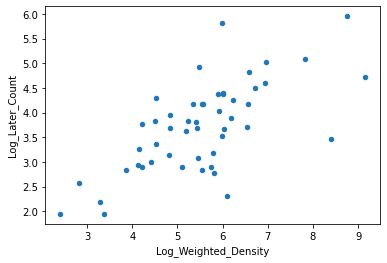

In [21]:

AxesSubplot_obj = density_df.plot.scatter(x='Log_Weighted_Density', y='Log_Later_Count')

In [49]:

from scipy.stats import pearsonr
import seaborn as sns

density_df = s.load_object('density_df')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        state_abbreviation = point.val
        x = point.x
        y = point.y
        kwargs = dict(textcoords='offset points', ha='left', va='bottom', fontsize='small',
                      bbox=dict(boxstyle='round,pad=0.5', fc=color_dict[state_abbreviation], alpha=0.5))
        annotation = plt.annotate('{}'.format(state_abbreviation), xy=(x, y), xytext=(-5, -8), **kwargs)
        #ax.text(point['x']+.02, point['y'], state_abbreviation)

facebook_aspect_ratio = 1.91
twitter_aspect_ratio = 16/9
color_dict = s.load_object('states_abbreviation_color_dict')
def plot_lived_density(qe_column='Population_Density', qr_column='Later_Count',
                       xlabel='Lived population density', ylabel='No. of deaths 10 days after hitting 5 deaths', aspect_ratio=1.91):
    columns_list = [qe_column, qr_column]
    df = density_df[columns_list].dropna(axis='index', how='any')
    x = df[qe_column]
    y = df[qr_column]
    facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df, scatter=True, scatter_kws={'s': 0.0})
    set_list = facet_grid.set(xlabel=xlabel, ylabel=ylabel,
                              title='Rate of spread vs Lived population density')
    fig_width = 18
    fig_height = fig_width/aspect_ratio
    set_list = facet_grid.fig.set(figheight=fig_height, figwidth=fig_width)
    
    # Get r squared value
    pearsonr_tuple = pearsonr(df[qe_column], df[qr_column])
    pearson_r = pearsonr_tuple[0]
    pearsonr_statement = str('%.2f' % pearson_r)
    coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
    p_value = pearsonr_tuple[1]
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    s_str = r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'
    set_list = facet_grid.fig.text(0.75, 0.9, s_str, alpha=0.5, fontsize='x-large')

    label_point(df[qe_column], df[qr_column], df.index.to_series(), plt.gca())
    
    ax = facet_grid.ax
    ax.set_alpha = 0.0
    left, right = ax.get_xlim()
    left -= 0.125
    right += 0.125
    xlim_tuple = (left, right)
    xlim_tuple = ax.set_xlim(xlim_tuple)

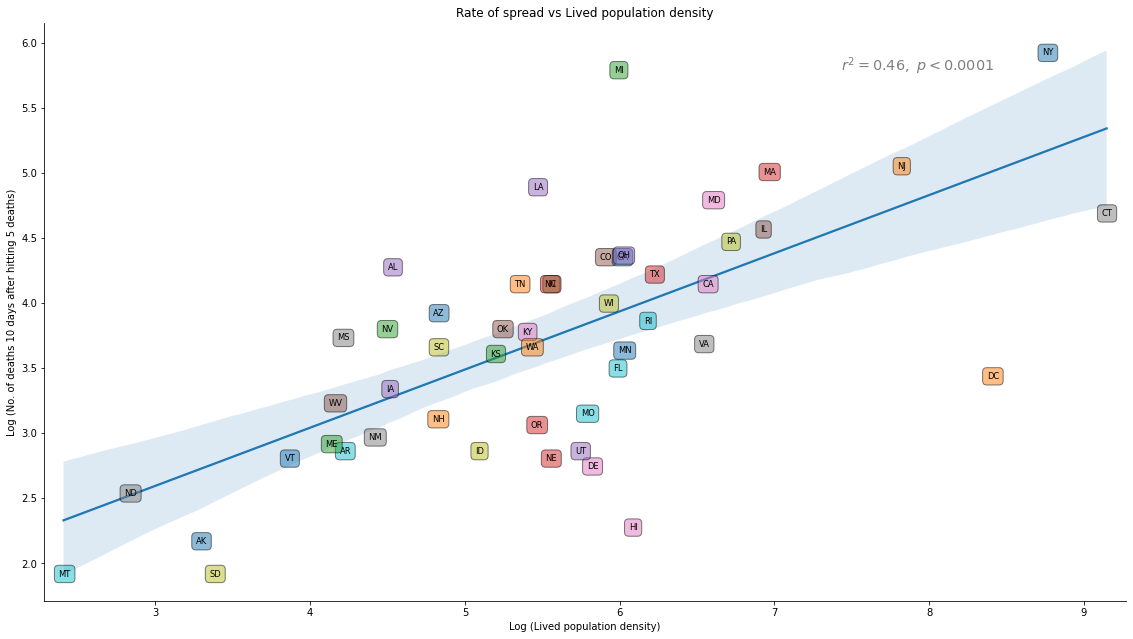

In [50]:

plot_lived_density(qe_column='Log_Weighted_Density', qr_column='Log_Later_Count',
                   xlabel='Log (Lived population density)', ylabel='Log (No. of deaths 10 days after hitting 5 deaths)',
                   aspect_ratio=facebook_aspect_ratio)

['facet_grid.add_legend', 'facet_grid.ax', 'facet_grid.axes', 'facet_grid.col_names', 'facet_grid.data', 'facet_grid.despine', 'facet_grid.facet_axis', 'facet_grid.facet_data', 'facet_grid.fig', 'facet_grid.hue_kws', 'facet_grid.hue_names', 'facet_grid.map', 'facet_grid.map_dataframe', 'facet_grid.row_names', 'facet_grid.savefig', 'facet_grid.set', 'facet_grid.set_axis_labels', 'facet_grid.set_titles', 'facet_grid.set_xlabels', 'facet_grid.set_xticklabels', 'facet_grid.set_ylabels', 'facet_grid.set_yticklabels']


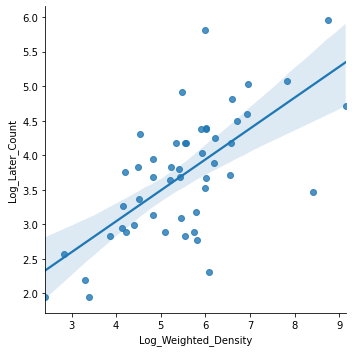

In [33]:

qe_column='Log_Weighted_Density'
qr_column='Log_Later_Count'
xlabel='Lived population density'
ylabel='No. of deaths 10 days after hitting 5 deaths'
aspect_ratio=1.91
columns_list = [qe_column, qr_column]
df = density_df[columns_list].dropna(axis='index', how='any')
x = df[qe_column]
y = df[qr_column]
facet_grid = sns.lmplot(x=qe_column, y=qr_column, data=df, scatter=True)
print(['facet_grid.{}'.format(fn) for fn in dir(facet_grid) if not fn.startswith('_')])

In [38]:

ax = facet_grid.ax
print(['ax.{}'.format(fn) for fn in dir(ax) if 'alpha' in fn.lower()])
ax.set_alpha?

['ax._alpha', 'ax.get_alpha', 'ax.set_alpha']


Signature: ax.set_alpha(alpha)
Docstring:
Set the alpha value used for blending - not supported on all backends.

Parameters
----------
alpha : float or None
File:      c:\users\577342\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\artist.py
Type:      method


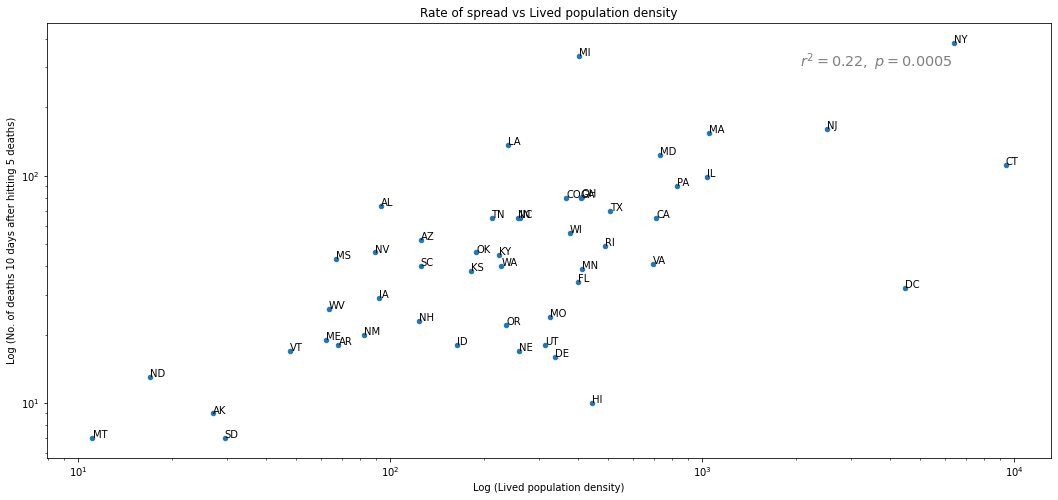

In [16]:

from scipy import stats
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111, autoscale_on=True)
ax.set_xscale('log')
ax.set_yscale('log')
columns_list = ['Weighted_Density', 'Later_Count']
df = density_df[columns_list].dropna(axis='index', how='any')
x = df['Weighted_Density']
y = df['Later_Count']

'''
# Compute the slope, intercept and 90% confidence interval.
# For comparison, also compute the least-squares fit with linregress:
res = stats.theilslopes(np.log(y), np.log(x), 0.90)
lsq_res = stats.linregress(np.log(x), np.log(y))

# Plot the results
ax.plot(x, lsq_res[1] + lsq_res[0] * x, 'g-')
ax.plot(x, res[1] + res[0] * x, 'r-')
ax.plot(x, res[1] + res[2] * x, 'r--')
ax.plot(x, res[1] + res[3] * x, 'r--')'''

# Get r squared value
pearsonr_tuple = pearsonr(x, y)
pearson_r = pearsonr_tuple[0]
pearsonr_statement = str('%.2f' % pearson_r)
coefficient_of_determination_statement = str('%.2f' % pearson_r**2)
p_value = pearsonr_tuple[1]
if p_value < 0.0001:
    pvalue_statement = '<0.0001'
else:
    pvalue_statement = '=' + str('%.4f' % p_value)
s_str = r'$r^2=' + coefficient_of_determination_statement + ',\ p' + pvalue_statement + '$'

text_tuple = ax.text(0.75, 0.9, s_str, alpha=0.5, transform=ax.transAxes, fontsize='x-large')
ax.set_title('Rate of spread vs Lived population density')
AxesSubplot_obj = density_df.plot.scatter(x='Weighted_Density', y='Later_Count', ax=ax)
ax.set_xlabel('Log (Lived population density)')
ax.set_ylabel('Log (No. of deaths 10 days after hitting 5 deaths)')
label_point(x, y, df.index.to_series(), plt.gca()) 

In [394]:

print(['page_obj.{}'.format(fn) for fn in dir(page_obj) if not fn.startswith('_')])

['page_obj.categories', 'page_obj.content', 'page_obj.coordinates', 'page_obj.html', 'page_obj.images', 'page_obj.links', 'page_obj.original_title', 'page_obj.pageid', 'page_obj.parent_id', 'page_obj.references', 'page_obj.revision_id', 'page_obj.section', 'page_obj.sections', 'page_obj.summary', 'page_obj.title', 'page_obj.url']


In [395]:

page_obj.pageid

'90885'

In [363]:

s.save_dataframes(counties_df=counties_df)

Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\counties_df.csv



----
# Clean the Data

In [54]:

counties_df = s.load_object('counties_df')
counties_df.Wikipedia_URL.sample(1).squeeze()

'https://en.wikipedia.org/wiki/Clinton_County,_Iowa'


----
## Create Density DataFrame

In [6]:

counties_df = s.load_object('counties_df')
state_groupby = counties_df.groupby('State_Name')
weighted_density_dict = {}
for state_name, state_df in state_groupby:
    state_population = state_df.Estimate_2019.sum()
    weighted_density = 0
    for row_index, row_series in state_df.iterrows():
        county_population = row_series.Estimate_2019
        county_area = row_series.Land_Area
        weighted_density += county_population**2/county_area
    weighted_density /= state_population
    weighted_density_dict[state_name] = weighted_density

In [10]:

density_df = pd.DataFrame.from_dict(weighted_density_dict, orient='index', columns=['Weighted_Density'])
density_df = pd.concat([states_stats_df.State_Abbreviation, density_df], axis='columns')
density_df.set_index('State_Abbreviation', drop=True, inplace=True)

In [11]:

# This is the standard population density calculation
columns_list = ['State_Abbreviation', 'State_Population', 'Land_Area_sq_km']
df = states_stats_df[columns_list]
df.set_index('State_Abbreviation', drop=True, inplace=True)
density_series = df.apply(lambda row_series: row_series.State_Population / row_series.Land_Area_sq_km, axis='columns')
density_series.name = 'Standard_Population_Density'
density_df = pd.concat([density_df, density_series], axis='columns')
#density_series

In [12]:

url = 'https://covidtracking.com/api/v1/states/daily.csv'
states_deaths_series = pd.read_csv(url,
                                   usecols=['date', 'state', 'death'],
                                   parse_dates=['date'],
                                   index_col=['state', 'date'],
                                   squeeze=True).sort_index()
states_deaths_series.fillna(value=0, inplace=True)
states_deaths_series = states_deaths_series.map(lambda x: int(x))

In [13]:

from datetime import timedelta

f_str = '{} hit {} deaths on {}. 10 days later, on {}, {} piled up {} carcasses.'
rows_list = []
for state_abbrev, deaths_series in states_deaths_series.groupby('state'):
    i = deaths_series.searchsorted(5, side='right', sorter=None)
    if i < len(deaths_series):
        death_count = deaths_series[i]
        index_tuple = deaths_series.index[i]
        hit_date = index_tuple[1]
        later_date = hit_date + timedelta(days=10)
        mask_series = (deaths_series.index.get_level_values('date') >= later_date)
        ds = deaths_series[mask_series]
        #print(state_abbrev, death_count, ds.shape[0])
        if ds.shape[0] > 0:
            later_count = ds.iloc[0]
            row_dict = {}
            row_dict['State_Abbreviation'] = state_abbrev
            row_dict['Later_Count'] = later_count
            rows_list.append(row_dict.copy())
            print(f_str.format(state_abbrev, death_count, hit_date.strftime('%B %d'),
                               later_date.strftime('%B %d'), state_abbrev, later_count))
density_df = pd.concat([density_df, pd.DataFrame(rows_list).set_index('State_Abbreviation', drop=True, inplace=False)], axis='columns')

AK hit 6 deaths on April 05. 10 days later, on April 15, AK piled up 9 carcasses.
AL hit 6 deaths on March 30. 10 days later, on April 09, AL piled up 74 carcasses.
AR hit 6 deaths on March 29. 10 days later, on April 08, AR piled up 18 carcasses.
AZ hit 6 deaths on March 25. 10 days later, on April 04, AZ piled up 52 carcasses.
CA hit 6 deaths on March 16. 10 days later, on March 26, CA piled up 65 carcasses.
CO hit 6 deaths on March 23. 10 days later, on April 02, CO piled up 80 carcasses.
CT hit 10 deaths on March 23. 10 days later, on April 02, CT piled up 112 carcasses.
DC hit 9 deaths on March 30. 10 days later, on April 09, DC piled up 32 carcasses.
DE hit 6 deaths on March 29. 10 days later, on April 08, DE piled up 16 carcasses.
FL hit 6 deaths on March 17. 10 days later, on March 27, FL piled up 34 carcasses.
GA hit 10 deaths on March 19. 10 days later, on March 29, GA piled up 80 carcasses.
HI hit 6 deaths on April 10. 10 days later, on April 20, HI piled up 10 carcasses.
IA

In [15]:

s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv


In [28]:

import numpy as np

density_df = s.load_object('density_df')
density_df['Log_Weighted_Density'] = density_df.Weighted_Density.map(lambda x: np.log(x))
density_df['Log_Later_Count'] = density_df.Later_Count.map(lambda x: np.log(x))
s.store_objects(density_df=density_df)
s.save_dataframes(include_index=True, density_df=density_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\density_df.pickle
Saving to D:\Documents\Repositories\notebooks\covid19\saves\csv\density_df.csv


In [400]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
from urllib.parse import unquote

counties_df = s.load_object('counties_df')
#counties_df['Wikipedia_ID'] = np.nan
mask_series = counties_df.Wikipedia_ID.isnull()
df = counties_df[mask_series]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    wikipedia_url = row_series.Wikipedia_URL
    title_str = '{}'.format(re.sub('_', ' ', wikipedia_url.split('/')[-1]))
    title_str = unquote(title_str)
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=False)
        wikipedia_id = page_obj.pageid
        counties_df.loc[row_index, 'Wikipedia_ID'] = wikipedia_id
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
    except KeyError as e:
        message = str(e).strip()
        print(message)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {wikipedia_url}
        break
s.store_objects(counties_df=counties_df)

'fullurl'
Opening in existing browser session.
Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle



C:\Program Files (x86)\Google\Chrome\Application\chrome.exe: invalid option -- `-u'
Try 'chrome.exe --help' for more information.
[0425/071144.763:ERROR:registration_protocol_win.cc(131)] TransactNamedPipe: The pipe has been ended. (0x6D)
[921576:936180:0425/071145.907:ERROR:cache_util_win.cc(21)] Unable to move the cache: Access is denied. (0x5)
[921576:936180:0425/071145.907:ERROR:cache_util.cc(138)] Unable to move cache folder C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\GPUCache to C:\Users\577342\AppData\Local\Google\Chrome\User Data\ShaderCache\old_GPUCache_000
[921576:936180:0425/071145.907:ERROR:disk_cache.cc(184)] Unable to create cache
[921576:936180:0425/071145.907:ERROR:shader_disk_cache.cc(606)] Shader Cache Creation failed: -2


In [401]:

counties_df.loc[row_index]

County_Name                                              O'Brien County
Census_2010                                                       14398
Estimates_Base                                                    14398
Estimate_2010                                                     14408
Estimate_2011                                                     14218
Estimate_2012                                                     14156
Estimate_2013                                                     14045
Estimate_2014                                                     14042
Estimate_2015                                                     13926
Estimate_2016                                                     13926
Estimate_2017                                                     13774
Estimate_2018                                                     13798
Estimate_2019                                                     13753
State_Name                                                      

In [403]:

from urllib.parse import unquote

wikipedia_url = row_series.Wikipedia_URL
title_str = '{}'.format(re.sub('_', ' ', wikipedia_url.split('/')[-1]))
title_str = unquote(title_str)
title_str

"O'Brien County, Iowa"

In [392]:

wikipedia_url = 'https://en.wikipedia.org/wiki/Hoonah%E2%80%93Angoon_Census_Area,_Alaska'
counties_df.loc[row_index, ''] = wikipedia_url
s.store_objects(counties_df=counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [393]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
#counties_df['Wikipedia_URL'] = np.nan
mask_series = counties_df.Wikipedia_URL.isnull()
df = counties_df[mask_series]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(re.sub(' city$', '', county_name), state_name)
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=False)
        wikipedia_url = page_obj.url
        counties_df.loc[row_index, 'Wikipedia_URL'] = wikipedia_url
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
s.store_objects(counties_df=counties_df)


Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [284]:

counties_df = s.load_object('counties_df')
area_regex = re.compile(r'([0-9,.]+)[\xa0 ]sq[\xa0 ]mi \(([0-9,.]+)[\xa0 ]km2\)|([0-9,.]+)[\xa0 ]km2 \(([0-9,.]+)[\xa0 ]sq[\xa0 ]mi\)')
def f(x):
    return_value = None
    if area_regex.fullmatch(str(x)):
        
        # Successful match at the start of the string
        match_obj = area_regex.search(str(x))
        if match_obj:
            left_sq_km = match_obj.group(2)
            right_sq_km = match_obj.group(4)
            
            if right_sq_km is None:
                return_value = left_sq_km
            elif left_sq_km is None:
                return_value = right_sq_km
            
            if return_value is not None:
                return_value = float(re.sub(',', '', return_value))
    if return_value is None:
        return_value = np.nan
    
    return return_value

counties_df.Land_Area = counties_df.Land_Area.map(f)
s.store_objects(counties_df=counties_df)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [262]:

from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

counties_df = s.load_object('counties_df')
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
mask_series = counties_df.Land_Area.isnull()
df = counties_df[mask_series][columns_list]
max_rows = df.shape[0]
pbar = tqdm(df.iterrows(), total=max_rows)
for row_index, row_series in pbar:
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(county_name, state_name)
    #print()
    #pbar.set_description('{}/{}: {}'.format(row_index, max_rows, title_str))
    pbar.set_description('{:<25}'.format(title_str)[:25])
    try:
        page_obj = wikipedia.page(title=title_str, auto_suggest=True)
        page_soup = bs(page_obj.html(), 'lxml')
        for param_th in page_soup.find_all('th', scope='row'):
            if(param_th.text.strip() == '•\xa0Land'):
                land_td = param_th.find_next_sibling('td')
                #print('Land Area: {}'.format(land_td.text))
                counties_df.loc[row_index, 'Land_Area'] = land_td.text
            if(param_th.text.strip() == '•\xa0Density'):
                density_td = param_th.find_next_sibling('td')
                #print('Population Density: {}'.format(density_td.text))
                counties_df.loc[row_index, 'Population_Density'] = density_td.text
    except wikipedia.PageError as e:
        message = str(e).strip()
        print(message)
        search_str = '+'.join(title_str.lower().split(' '))
        url = 'https://www.google.com/search?q={}+land+area'.format(search_str)
        !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
        break
    #clear_output(wait=True)
s.store_objects(counties_df=counties_df)


Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\counties_df.pickle


In [267]:

counties_df = s.load_object('counties_df')
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
mask_series = counties_df.Land_Area.isnull()
for row_index, row_series in counties_df[mask_series][columns_list].iterrows():
    county_name = row_series.County_Name
    state_name = row_series.State_Name
    title_str = '{}, {}'.format(county_name, state_name)
    print(title_str)
    search_str = '+'.join(title_str.lower().split(' '))
    url = 'https://www.google.com/search?q={}+land+area'.format(search_str)
    !"C:\Program Files (x86)\Google\Chrome\Application\chrome.exe" {url}
    break


---
# Scrape the Data

In [133]:

# https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres.xlsx
xlsx_dir = os.path.join(s.data_folder, 'xlsx')
file_path = os.path.join(xlsx_dir, 'co-est2019-annres.xlsx')
counties_df = pd.read_excel(file_path)
counties_df.columns = ['County_Name', 'Census_2010', 'Estimates_Base', 'Estimate_2010', 'Estimate_2011', 'Estimate_2012',
                       'Estimate_2013', 'Estimate_2014', 'Estimate_2015', 'Estimate_2016', 'Estimate_2017', 'Estimate_2018',
                       'Estimate_2019']
#counties_df.Country_Name.to_dict()
idx_list = list(range(4, 3146))
mask_series = counties_df.index.isin(idx_list)
counties_df = counties_df[mask_series]
counties_df['State_Name'] = counties_df.County_Name.map(lambda x: x.split(',')[1].strip())
counties_df.County_Name = counties_df.County_Name.map(lambda x: re.sub(r'\.(.+)', r'\g<1>', x.split(',')[0].strip(), 1))
counties_df.Estimate_2019 = counties_df.Estimate_2019.map(lambda x: int(x))
s.store_objects(counties_df=counties_df)
columns_list = ['County_Name', 'State_Name', 'Estimate_2019']
counties_df[columns_list].sample(5)

,County_Name,State_Name,Estimate_2019
3124,Big Horn County,Wyoming,11790
1082,Monroe County,Kentucky,10650
1675,Clay County,Nebraska,6203
912,Dickinson County,Kansas,18466
1880,Schuyler County,New York,17807


In [14]:

from datetime import datetime

tables_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area'
tables_list = get_page_tables(tables_url)

[(0, (60, 12)), (1, (9, 12)), (2, (4, 12)), (3, (11, 2))]


In [16]:

us_states_area_df = tables_list[0].copy()
us_states_area_df.columns = ['State_Name', 'Total_Area_Rank', 'Total_Area_sq_mi', 'Total_Area_sq_km', 'Land_Area_Rank',
                             'Land_Area_sq_mi', 'Land_Area_sq_km', 'Land_Area_Percent', 'Water_Rank', 'Water_sq_mi',
                             'Water_sq_km', 'Water_Percent']
us_states_area_df = us_states_area_df.iloc[:-3]
for column_name in us_states_area_df.columns:
    if column_name == 'State_Name':
        us_states_area_df[column_name] = us_states_area_df[column_name].map(lambda x: str(x).split('[')[0])
    else:
        us_states_area_df[column_name] = us_states_area_df[column_name].map(lambda x: re.sub('[^\d\.]+', '', str(x)))
        us_states_area_df[column_name] = pd.to_numeric(us_states_area_df[column_name], errors='coerce')
mask_series = (us_states_area_df.State_Name == 'United States Virgin Islands')
us_states_area_df.loc[mask_series, 'State_Name'] = 'U.S. Virgin Islands'
us_states_area_df.set_index('State_Name', drop=True, inplace=True)
s.store_objects(us_states_area_df=us_states_area_df)
us_states_area_df.sample(10).T.head(10)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_states_area_df.pickle


State_Name,Minnesota,Tennessee,Arkansas,Indiana,Massachusetts,Alabama,West Virginia,Minor Outlying Islands,New Hampshire,New Mexico
Total_Area_Rank,12.00,36.00,29.00,38.00,44.00,30.00,41.00,NaN,46.00,5.00
Total_Area_sq_mi,86935.83,42144.25,53178.55,36419.55,10554.39,52420.07,24230.04,16.0,9349.16,121590.30
Total_Area_sq_km,225163.00,109153.00,137732.00,94326.00,27336.00,135767.00,62756.00,41.0,24214.00,314917.00
Land_Area_Rank,14.00,34.00,27.00,38.00,45.00,28.00,41.00,NaN,44.00,5.00
Land_Area_sq_mi,79626.74,41234.90,52035.48,35826.11,7800.06,50645.33,24038.21,16.0,8952.65,121298.15
Land_Area_sq_km,206232.00,106798.00,134771.00,92789.00,20202.00,131171.00,62259.00,41.0,23187.00,314161.00
Land_Area_Percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Water_Rank,9.00,35.00,31.00,39.00,16.00,23.00,50.00,NaN,47.00,49.00
Water_sq_mi,7309.09,909.36,1143.07,593.44,2754.33,1774.74,191.83,NaN,396.51,292.15
Water_sq_km,18930.00,2355.00,2961.00,1537.00,7134.00,4597.00,497.00,NaN,1027.00,757.00
